In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


## set up pyspark session

In [3]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/03 11:59:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

In [5]:
os.getcwd()

'/app/MITB_MLE_A2'

In [7]:
gold_label = 'datamart/gold/label_store/'
label_list = [gold_label+os.path.basename(f) for f in glob.glob(os.path.join(gold_label, '*'))]
label_df = spark.read.option("header", "true").parquet(*label_list).toPandas()
len(label_df)

8974

In [11]:
gold_feature = 'datamart/gold/feature_store/eng/'
files_list = [gold_feature+os.path.basename(f) for f in glob.glob(os.path.join(gold_feature, '*'))]
eng_df = spark.read.option("header", "true").parquet(*files_list).toPandas()
print('loaded from:', gold_feature, 'row count:', eng_df.count())

loaded from: utils/datamart/gold/feature_store/eng/ row count: Customer_ID      215376
snapshot_date    215376
click_1m         206402
click_2m         197428
click_3m         188454
click_4m         179480
click_5m         170506
click_6m         161532
dtype: int64


In [13]:
eng_df.sort_values("Customer_ID").head()

,Customer_ID,snapshot_date,click_1m,click_2m,click_3m,click_4m,click_5m,click_6m
30038,CUS_0x1000,2024-04-01,115.0,-35.0,224.0,172.0,-13.0,150.0
65934,CUS_0x1000,2024-10-01,90.0,-128.0,81.0,68.0,108.0,65.0
92856,CUS_0x1000,2024-11-01,42.0,90.0,-128.0,81.0,68.0,108.0
209469,CUS_0x1000,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN
110804,CUS_0x1000,2023-09-01,135.0,68.0,201.0,58.0,92.0,-19.0


In [4]:
gold_feature = 'datamart/gold/feature_store/cust_fin_risk/'
files_list = [gold_feature+os.path.basename(f) for f in glob.glob(os.path.join(gold_feature, '*'))]
df = spark.read.option("header", "true").parquet(*files_list).toPandas()
print('loaded from:', gold_feature, 'row count:', df.count())

[Stage 2:>                                                        (0 + 24) / 24]

loaded from: datamart/gold/feature_store/cust_fin_risk/ row count: Customer_ID              11974
Credit_History_Age       11974
Loans_per_Credit_Item    11974
Debt_to_Salary           11974
Loan_Extent              11974
Outstanding_Debt         11974
Interest_Rate            11974
Delay_from_due_date      11974
Changed_Credit_Limit     11728
Payment_Behaviour        11021
Age                      11670
Occupation               11974
dtype: int64


In [5]:
len(df)

11974

In [7]:
df["Customer_ID"].nunique()

11974

Each ID is unique (no overlapping record)

In [6]:
df.sort_values("Customer_ID").head()

,Customer_ID,Credit_History_Age,Loans_per_Credit_Item,Debt_to_Salary,Loan_Extent,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit,Payment_Behaviour,Age,Occupation
1073,CUS_0x1000,129,0.166667,0.577324,114.0,1562.91,27.0,57,1.63,4.0,18.0,7
2112,CUS_0x100b,190,0.000000,0.107866,0.0,1030.20,1.0,14,8.34,3.0,19.0,10
6688,CUS_0x1011,190,0.428571,0.090816,81.0,473.14,17.0,27,14.42,1.0,44.0,3
9138,CUS_0x1013,214,0.428571,0.154897,36.0,1233.51,6.0,12,1.33,4.0,44.0,9
10112,CUS_0x1015,257,0.000000,0.091295,0.0,340.22,16.0,8,15.83,0.0,27.0,6


In [8]:
df.isna().sum()

Customer_ID                0
Credit_History_Age         0
Loans_per_Credit_Item      0
Debt_to_Salary             0
Loan_Extent                0
Outstanding_Debt           0
Interest_Rate              0
Delay_from_due_date        0
Changed_Credit_Limit     246
Payment_Behaviour        953
Age                      304
Occupation                 0
dtype: int64

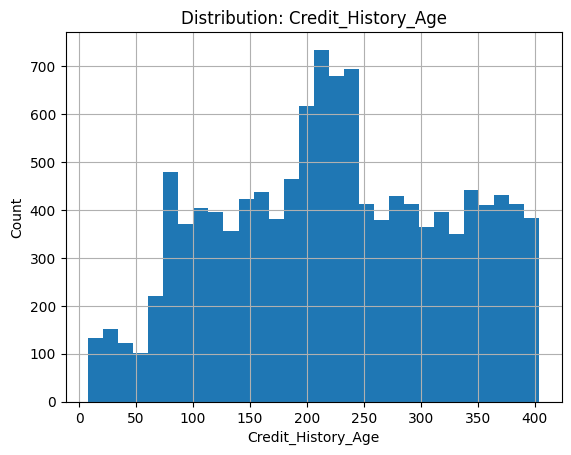

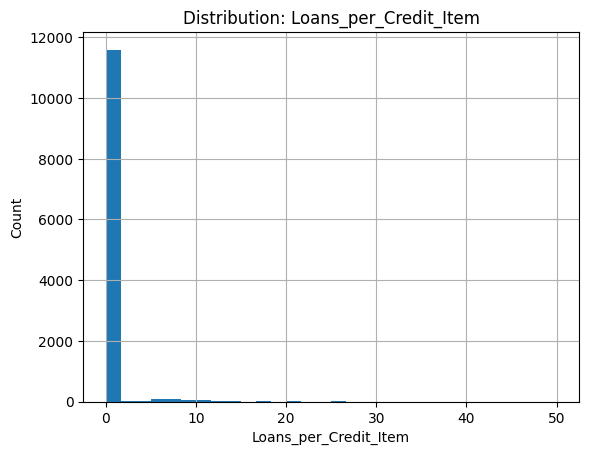

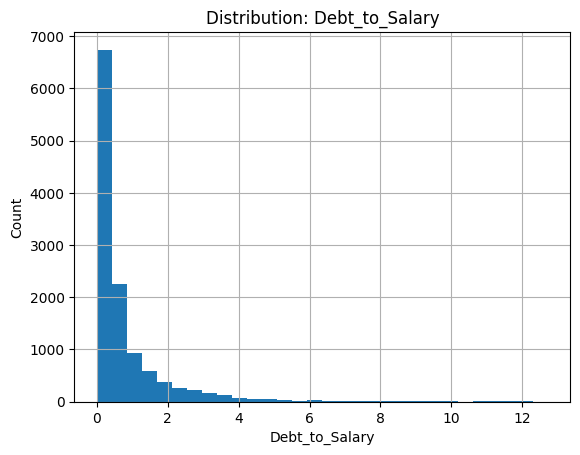

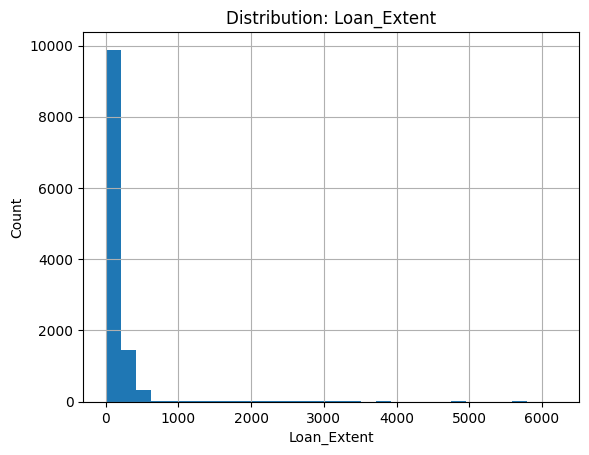

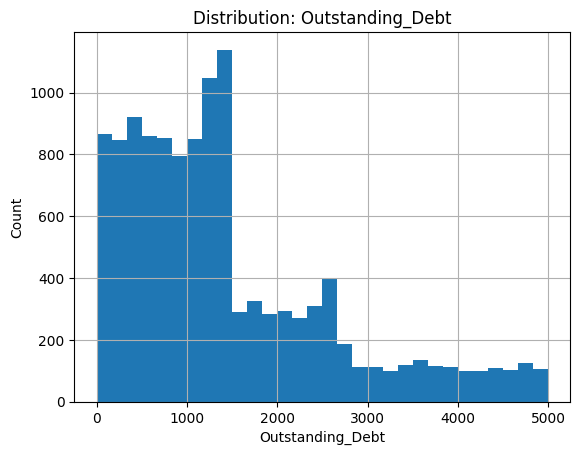

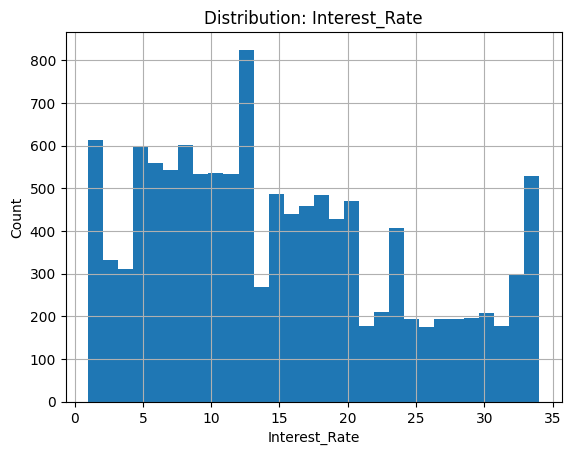

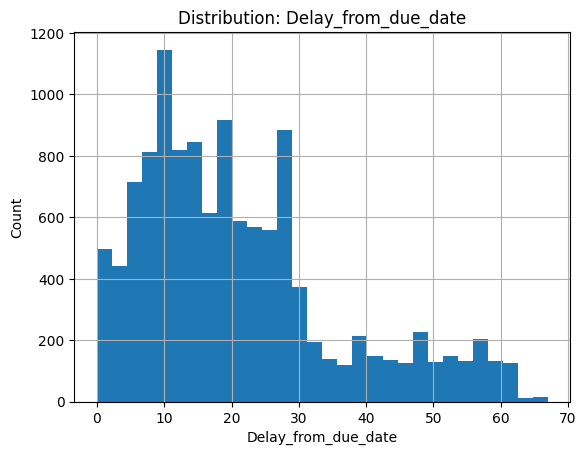

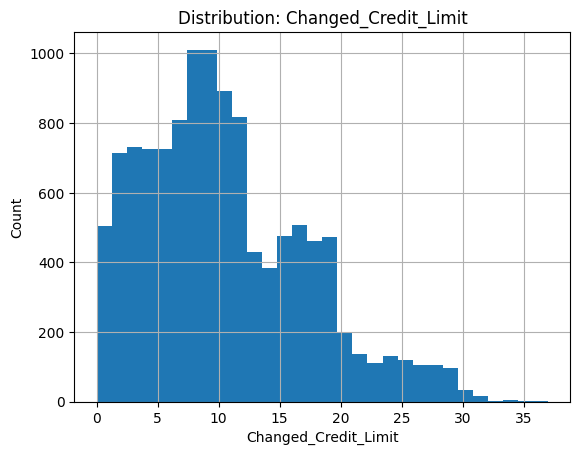

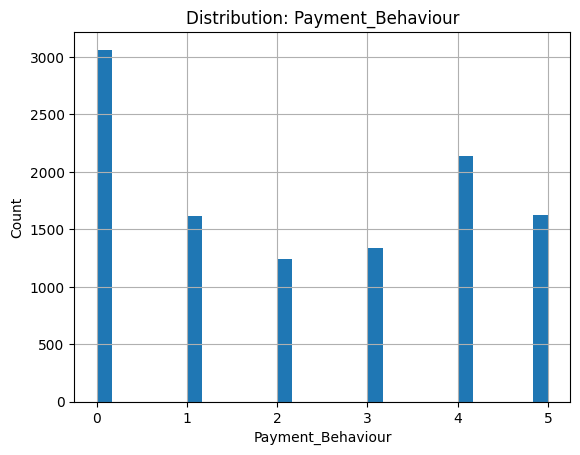

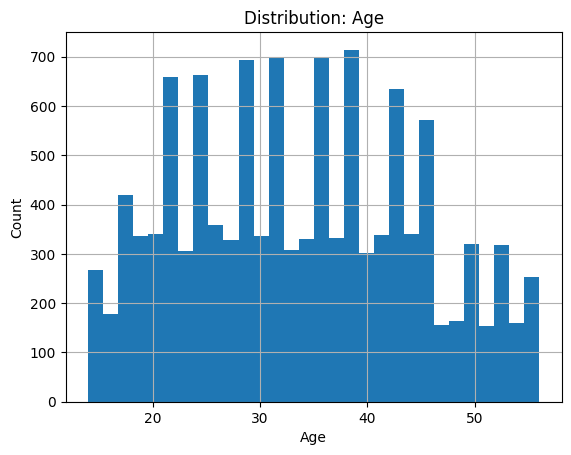

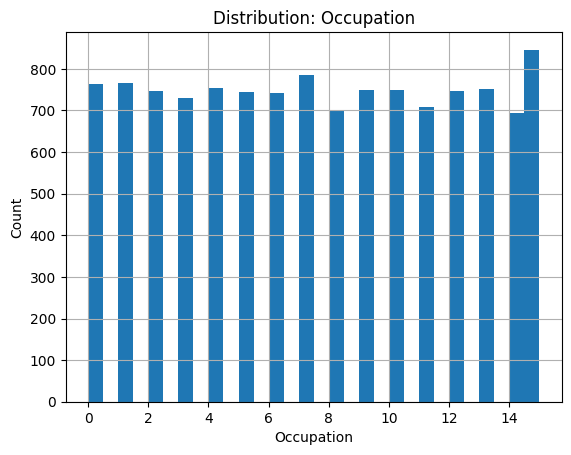

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# # If snapshot_date might be a string, coerce it to datetime first
# df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], errors='coerce')

# cols = [
#     'Customer_ID','Credit_History_Age','Loans_per_Credit_Item','Debt_to_Salary',
#     'Loan_Extent','Outstanding_Debt','Interest_Rate','Delay_from_due_date',
#     'Changed_Credit_Limit','Payment_Behaviour','Age','Occupation',
#     'click_mean_6m','click_std_6m','snapshot_date'
# ]

cols = [
    'Customer_ID','Credit_History_Age','Loans_per_Credit_Item','Debt_to_Salary',
    'Loan_Extent','Outstanding_Debt','Interest_Rate','Delay_from_due_date',
    'Changed_Credit_Limit','Payment_Behaviour','Age','Occupation',
]

# (Optional) drop obvious identifiers from distribution plots
plot_cols = [c for c in cols if c not in ['Customer_ID', 'snapshot_date']]

# Split into numeric vs categorical for plotting
numeric_cols = df[plot_cols].select_dtypes(include='number').columns.tolist()
categorical_cols = [c for c in plot_cols if c not in numeric_cols]

# ---------- Numeric distributions ----------
for c in numeric_cols:
    plt.figure()
    df[c].dropna().hist(bins=30)
    plt.title(f'Distribution: {c}')
    plt.xlabel(c)
    plt.ylabel('Count')
    plt.show()

# ---------- Categorical distributions (top categories) ----------
for c in categorical_cols:
    plt.figure()
    df[c].astype('category').value_counts(dropna=False).head(25).plot(kind='bar')
    plt.title(f'Category counts: {c} (top 25)')
    plt.xlabel(c)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [20]:

# ---------- View rows with missing snapshot_date ----------
missing_snap = df[df['snapshot_date'].isna()]
print("Rows with missing snapshot_date (head):")
display(missing_snap.head(20))

Rows with missing snapshot_date (head):


,Customer_ID,Credit_History_Age,Loans_per_Credit_Item,Debt_to_Salary,Loan_Extent,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit,Payment_Behaviour,Age,Occupation,click_mean_6m,click_std_6m,snapshot_date
8444,CUS_0x10ac,195,0.363636,0.671331,104.0,853.41,15.0,26,18.45,NaN,29.0,2.0,NaN,NaN,NaT
8445,CUS_0x10c5,362,0.100000,0.086092,10.0,1134.83,10.0,10,6.04,4.0,24.0,NaN,NaN,NaN,NaT
8446,CUS_0x1145,149,0.750000,0.873548,549.0,1263.10,32.0,61,8.90,0.0,24.0,13.0,NaN,NaN,NaT
8447,CUS_0x11ac,209,0.000000,0.081115,0.0,478.85,14.0,14,7.18,0.0,26.0,6.0,NaN,NaN,NaT
8448,CUS_0x122c,266,0.200000,0.392640,63.0,1252.46,11.0,21,10.54,4.0,48.0,5.0,NaN,NaN,NaT
8449,CUS_0x1274,71,0.230769,0.436014,39.0,1800.41,34.0,13,12.81,0.0,NaN,12.0,NaN,NaN,NaT
8450,CUS_0x1288,65,0.421053,0.764350,208.0,3947.24,31.0,26,17.49,2.0,34.0,3.0,NaN,NaN,NaT
8451,CUS_0x12cc,129,0.157895,1.101426,63.0,1896.78,17.0,21,14.94,NaN,30.0,2.0,NaN,NaN,NaT
8452,CUS_0x1338,166,0.380952,3.138607,344.0,4545.35,31.0,43,25.27,0.0,40.0,NaN,NaN,NaN,NaT
8453,CUS_0x1370,146,0.263158,6.298570,100.0,3703.66,22.0,20,19.55,4.0,32.0,14.0,NaN,NaN,NaT


In [5]:
gold_label = 'datamart/gold/label_store/'
files_list = [gold_label+os.path.basename(f) for f in glob.glob(os.path.join(gold_label, '*'))]
label_df = spark.read.option("header", "true").parquet(*files_list).toPandas()
print('loaded from:', gold_label, 'row count:', label_df.count())

loaded from: datamart/gold/label_store/ row count: loan_id          8974
Customer_ID      8974
label            8974
label_def        8974
snapshot_date    8974
dtype: int64


In [7]:
label_df['snapshot_date'].min()

datetime.date(2023, 7, 1)

## Check training join


In [5]:
    model_train_date_str = "2024-09-01" #"2024-09-01" should be the first model training date
    train_test_period_months = 12
    oot_period_months = 2
    train_test_ratio = 0.8

    config = {}
    config["model_train_date_str"] = model_train_date_str
    config["train_test_period_months"] = train_test_period_months
    config["oot_period_months"] =  oot_period_months
    config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
    config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
    config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
    config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
    config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
    config["train_test_ratio"] = train_test_ratio 
    config["random_state"] = 42

In [6]:
#==========================
# Label store
#==========================
label_folder_path = "datamart/gold/label_store/"
label_files_list = [label_folder_path+os.path.basename(f) for f in glob.glob(os.path.join(label_folder_path, '*'))]
label_store_sdf = spark.read.option("header", "true").parquet(*label_files_list)
# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

#==========================
# Feature store
#==========================
features_folder_path = "datamart/gold/feature_store/cust_fin_risk/"
features_files_list = [features_folder_path+os.path.basename(f) for f in glob.glob(os.path.join(features_folder_path, '*'))]
features_store_sdf = spark.read.option("header", "true").parquet(*features_files_list)

#====================================
# Data Processing for Model Training
#====================================
# prepare data for modeling
data_pdf = labels_sdf.join(features_store_sdf, on=["Customer_ID"], how="left").toPandas()
# split data into train - test - oot
oot_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & (data_pdf['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) & (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())]
feature_cols = [col for col in data_pdf.columns if col not in ('Customer_ID', 'snapshot_date', 'label')]

train_test_pdf.head()

,Customer_ID,loan_id,label,label_def,snapshot_date,Credit_History_Age,Loans_per_Credit_Item,Debt_to_Salary,Loan_Extent,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit,Payment_Behaviour,Age,Occupation
0,CUS_0x1037,CUS_0x1037_2023_01_01,0,30dpd_6mob,2023-07-01,237,0.400000,0.612291,52.0,665.82,2.0,13,0.50,0.0,45.0,0
1,CUS_0x1069,CUS_0x1069_2023_01_01,0,30dpd_6mob,2023-07-01,368,9.090909,0.043496,900.0,208.80,10.0,9,12.56,3.0,32.0,0
2,CUS_0x114a,CUS_0x114a_2023_01_01,0,30dpd_6mob,2023-07-01,189,0.250000,0.521676,28.0,642.42,2.0,14,15.95,0.0,43.0,2
3,CUS_0x1184,CUS_0x1184_2023_01_01,0,30dpd_6mob,2023-07-01,392,0.333333,0.506066,30.0,707.29,11.0,10,6.74,NaN,49.0,7
4,CUS_0x1297,CUS_0x1297_2023_01_01,1,30dpd_6mob,2023-07-01,164,0.500000,0.802144,549.0,3916.47,30.0,61,14.27,4.0,46.0,8
